# Importing Libraries and loading in data

In [1]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
from matplotlib.pyplot import *
from glob import glob
import glob
import os
import datetime
import pandas as pd
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio

In [2]:
def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    time_str = os.path.basename(filename)[17:-13]
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj
    
    return da

# Validating Southampton Centre
## Extracting data at the ground site

In [5]:
a = MAIAC_PM25.attrs['affine']
a = rasterio.Affine.from_gdal(*a)
~a * (442579, 112248)

(1106.3836110057598, 1048.137442006313)

In [6]:
folders = glob.glob(r'D:\MAIAC_Data\Europe\h00v01\Projected\20*')

In [7]:
for folder in folders:
    files = glob.glob(r'{fname}\*_PM25.tif'.format(fname=folder))
    list_of_das = map(maiac_file_to_da, files)
    MAIAC_PM25 = xr.concat(list_of_das, 'time')
    reordered_MAIAC_PM25 = MAIAC_PM25.isel(time=np.argsort(MAIAC_PM25.time))
    Measurements = reordered_MAIAC_PM25.isel(x=1106, y=1048).dropna('time').to_dataframe(name='MAIAC_PM25')
    Measurements.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_MAIAC_PM25.csv', mode='a')
    print('Processed {fname}'.format(fname=folder))

Processed D:\MAIAC_Data\Europe\h00v01\Projected\2000
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2001
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2002
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2003
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2004
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2005
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2006
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2007
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2008
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2009
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2010
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2011
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2012
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2013
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2014


## Comparing the MAIAC and groundbased data

In [2]:
!head -n 30 'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Southampton2008_2014.csv'

Date,Time,PM2.5_Soton_Centre,Status
06/11/2008,01:00:00,26,V ugm-3 (TEOM FDMS)
06/11/2008,02:00:00,18,V ugm-3 (TEOM FDMS)
06/11/2008,03:00:00,19,V ugm-3 (TEOM FDMS)
06/11/2008,04:00:00,22,V ugm-3 (TEOM FDMS)
06/11/2008,05:00:00,25,V ugm-3 (TEOM FDMS)
06/11/2008,06:00:00,36,V ugm-3 (TEOM FDMS)
06/11/2008,07:00:00,39,V ugm-3 (TEOM FDMS)
06/11/2008,08:00:00,37,V ugm-3 (TEOM FDMS)
06/11/2008,09:00:00,41,V ugm-3 (TEOM FDMS)
06/11/2008,10:00:00,32,V ugm-3 (TEOM FDMS)
06/11/2008,11:00:00,31,V ugm-3 (TEOM FDMS)
06/11/2008,12:00:00,36,V ugm-3 (TEOM FDMS)
06/11/2008,13:00:00,33,V ugm-3 (TEOM FDMS)
06/11/2008,14:00:00,25,V ugm-3 (TEOM FDMS)
06/11/2008,15:00:00,30,V ugm-3 (TEOM FDMS)
06/11/2008,16:00:00,28,V ugm-3 (TEOM FDMS)
06/11/2008,17:00:00,26,V ugm-3 (TEOM FDMS)
06/11/2008,18:00:00,32,V ugm-3 (TEOM FDMS)
06/11/2008,19:00:00,36,V ugm-3 (TEOM FDMS)
06/11/2008,20:00:00,38,V ugm-3 (TEOM FDMS)
06/11/2008,21:00:00,34,V ugm-3 (TEOM FDMS)
06/11/2008,22:00:00,32,V ugm-3 (TEOM FDMS)
06/11/2008,23:00:0

In [2]:
AURN_Soton = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Southampton2008_2014.csv', 
                         parse_dates = {'timestamp': ['Date', 'Time']}, infer_datetime_format=True, dayfirst=True, na_values=['No data'])

In [3]:
from dateutil.parser import parse

In [4]:
AURN_Soton['Had24'] = AURN_Soton.timestamp.str.contains(' 24:')

In [5]:
AURN_Soton['timestamp'] = AURN_Soton.timestamp.str.replace(' 24:', ' 00:')

In [6]:
AURN_Soton['timestamp'] = pd.to_datetime(AURN_Soton.timestamp, format='%d/%m/%Y %H:%M:%S')

In [7]:
AURN_Soton.loc[AURN_Soton.Had24, 'timestamp'] = AURN_Soton.query('Had24 == True').timestamp + pd.Timedelta('1d')

In [8]:
AURN_Soton = AURN_Soton.set_index('timestamp')

In [9]:
AURN_Soton.head()

,PM2.5_Soton_Centre,Status,Had24
timestamp,,,
2008-11-06 01:00:00,26.0,V ugm-3 (TEOM FDMS),False
2008-11-06 02:00:00,18.0,V ugm-3 (TEOM FDMS),False
2008-11-06 03:00:00,19.0,V ugm-3 (TEOM FDMS),False
2008-11-06 04:00:00,22.0,V ugm-3 (TEOM FDMS),False
2008-11-06 05:00:00,25.0,V ugm-3 (TEOM FDMS),False


In [10]:
AURN_Soton.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\AURN_Soton.csv')

In [11]:
MAIAC_Soton = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_MAIAC_PM25.csv', parse_dates=['time'])

In [12]:
MAIAC_Soton = MAIAC_Soton.set_index('time')

In [13]:
MAIAC_Soton.head()

,x,y,MAIAC_PM25
time,,,
2000-02-25 10:50:00,442096.9763,112420.7018,23.026955
2000-02-28 11:25:00,442096.9763,112420.7018,36.062874
2000-03-03 12:35:00,442096.9763,112420.7018,20.079552
2000-12-03 12:30:00,442096.9763,112420.7018,25.816568
2000-08-04 10:35:00,442096.9763,112420.7018,27.164116


In [14]:
MAIAC_Soton['time'] = MAIAC_Soton.index

In [15]:
MAIAC_Soton = MAIAC_Soton.drop_duplicates(subset='time')

In [16]:
MAIAC_Soton = MAIAC_Soton.sort_index()

In [17]:
indexed = MAIAC_Soton.reindex(AURN_Soton.index, method='nearest', tolerance='10Min').dropna()

In [18]:
result = pd.merge(AURN_Soton, indexed, left_index=True, right_index=True).reset_index().rename(columns={'time':'AURN_Time', 'timestamp':'MAIAC_Time', 'PM2.5_Soton_Centre':'PM25_Soton_Centre'})

In [19]:
result = result[['MAIAC_Time', 'AURN_Time', 'PM25_Soton_Centre', 'MAIAC_PM25']].dropna()

In [20]:
result[:10]

,MAIAC_Time,AURN_Time,PM25_Soton_Centre,MAIAC_PM25
0,2008-11-11 11:00:00,2008-11-11 10:50:00,10.0,12.274618
1,2008-11-25 11:00:00,2008-11-25 11:00:00,8.0,8.841886
2,2008-11-25 13:00:00,2008-11-25 12:50:00,5.0,8.425797
3,2008-12-01 11:00:00,2008-12-01 10:50:00,9.0,5.013084
4,2008-12-02 12:00:00,2008-12-02 11:55:00,6.0,5.804315
5,2008-12-03 13:00:00,2008-12-03 13:05:00,18.0,14.432179
6,2008-12-04 12:00:00,2008-12-04 12:10:00,6.0,20.042711
7,2008-12-04 14:00:00,2008-12-04 14:00:00,6.0,20.336378
8,2008-12-10 14:00:00,2008-12-10 14:05:00,10.0,3.511345
9,2008-12-17 12:00:00,2008-12-17 12:05:00,6.0,4.569387


In [21]:
result = result.set_index('MAIAC_Time')

In [22]:
result.isnull().sum()

AURN_Time            0
PM25_Soton_Centre    0
MAIAC_PM25           0
dtype: int64

In [23]:
%matplotlib inline

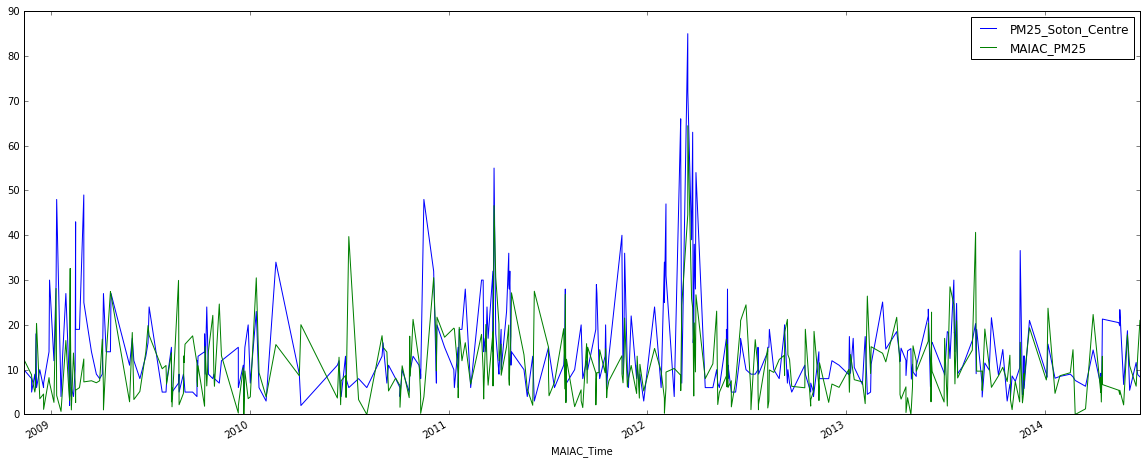

In [46]:
result.plot(figsize=(20, 8))
savefig(r'D:\Annies_Dissertation\Analysis\Soton_validation_graph.jpeg')

In [24]:
result['error'] = result['PM25_Soton_Centre'] - result['MAIAC_PM25']

In [25]:
result.error.abs().describe()

count    362.000000
mean       8.059675
std        8.499346
min        0.038878
25%        2.281614
50%        5.484178
75%       10.943085
max       57.245951
Name: error, dtype: float64

In [26]:
(result.error > 20).sum()

23

In [27]:
len(result)

362

In [28]:
result.ix[result.MAIAC_PM25 > 25]

,AURN_Time,PM25_Soton_Centre,MAIAC_PM25,error
MAIAC_Time,,,,
2009-01-09 12:00:00,2009-01-09 12:05:00,29.0,28.123997,0.876003
2009-02-04 11:00:00,2009-02-04 11:05:00,12.0,32.596939,-20.596939
2009-04-19 10:00:00,2009-04-19 10:05:00,14.0,27.457783,-13.457783
2009-04-20 11:00:00,2009-04-20 10:50:00,27.0,26.723618,0.276382
2009-08-22 13:00:00,2009-08-22 13:05:00,7.0,29.930033,-22.930033
2010-01-12 11:00:00,2010-01-12 11:00:00,23.0,30.500658,-7.500658
2010-07-01 12:00:00,2010-07-01 12:00:00,6.0,39.711491,-33.711491
2010-12-04 11:00:00,2010-12-04 11:10:00,32.0,30.541275,1.458725
2011-03-25 11:00:00,2011-03-25 10:50:00,55.0,46.613247,8.386753


In [29]:
result.ix[result.PM25_Soton_Centre > 25]

,AURN_Time,PM25_Soton_Centre,MAIAC_PM25,error
MAIAC_Time,,,,
2008-12-28 12:00:00,2008-12-28 11:55:00,30.0,7.082550,22.917450
2009-01-09 12:00:00,2009-01-09 12:05:00,29.0,28.123997,0.876003
2009-01-10 14:00:00,2009-01-10 13:55:00,48.0,4.246278,43.753722
2009-01-27 12:00:00,2009-01-27 12:00:00,27.0,16.513691,10.486309
2009-02-14 10:00:00,2009-02-14 10:05:00,43.0,2.664276,40.335724
2009-03-01 11:00:00,2009-03-01 11:10:00,49.0,12.385267,36.614733
2009-04-06 12:00:00,2009-04-06 12:00:00,27.0,5.913554,21.086446
2009-04-06 14:00:00,2009-04-06 13:50:00,27.0,1.019578,25.980422
2009-04-20 11:00:00,2009-04-20 10:50:00,27.0,26.723618,0.276382


In [32]:
result.ix[result.MAIAC_PM25 > 10]

,AURN_Time,PM2.5_Soton_Centre,MAIAC_PM25,error
MAIAC_Time,,,,
2008-11-11 11:00:00,2008-11-11 10:50:00,10.0,12.274618,-2.274618
2008-12-03 13:00:00,2008-12-03 13:05:00,18.0,14.432179,3.567821
2008-12-04 12:00:00,2008-12-04 12:10:00,6.0,20.042711,-14.042711
2008-12-04 14:00:00,2008-12-04 14:00:00,6.0,20.336378,-14.336378
2009-01-09 12:00:00,2009-01-09 12:05:00,29.0,28.123997,0.876003
2009-01-27 12:00:00,2009-01-27 12:00:00,27.0,16.513691,10.486309
2009-02-03 12:00:00,2009-02-03 12:00:00,4.0,18.376377,-14.376377
2009-02-04 11:00:00,2009-02-04 11:05:00,12.0,32.596939,-20.596939
2009-02-04 13:00:00,2009-02-04 12:55:00,14.0,22.685707,-8.685707


In [50]:
result.ix[result.PM25_Soton_Centre > 10]

,AURN_Time,PM25_Soton_Centre,MAIAC_PM25,error
MAIAC_Time,,,,
2008-12-03 13:00:00,2008-12-03 13:05:00,18.0,14.432179,3.567821
2008-12-27 13:00:00,2008-12-27 12:50:00,14.0,8.224896,5.775104
2008-12-28 12:00:00,2008-12-28 11:55:00,30.0,7.082550,22.917450
2009-01-05 14:00:00,2009-01-05 14:05:00,12.0,2.704527,9.295473
2009-01-09 12:00:00,2009-01-09 12:05:00,29.0,28.123997,0.876003
2009-01-10 14:00:00,2009-01-10 13:55:00,48.0,4.246278,43.753722
2009-01-21 11:00:00,2009-01-21 10:55:00,13.0,5.799451,7.200549
2009-01-27 12:00:00,2009-01-27 12:00:00,27.0,16.513691,10.486309
2009-02-01 14:00:00,2009-02-01 13:50:00,11.0,6.094338,4.905662


In [51]:
result.MAIAC_PM25.describe()

count    362.000000
mean      10.937988
std        8.309973
min        0.000000
25%        5.220956
50%        8.942549
75%       15.107771
max       64.451775
Name: MAIAC_PM25, dtype: float64

In [52]:
result.PM25_Soton_Centre.describe()

count    362.000000
mean      14.367127
std       11.175864
min        2.000000
25%        8.000000
50%       11.000000
75%       18.000000
max       85.000000
Name: PM25_Soton_Centre, dtype: float64

In [31]:
result.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_validation.csv')

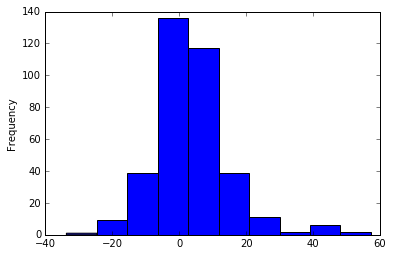

In [24]:
Soton_error_histo = result.error.plot.hist()
savefig(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_error_histo.jpeg')

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_true = result.PM25_Soton_Centre, y_pred = result.MAIAC_PM25))
rmse

11.70460144875577

In [26]:
from sklearn.metrics import mean_absolute_error
me = mean_absolute_error(y_true = result.PM25_Soton_Centre, y_pred = result.MAIAC_PM25)
me

8.0596748938287295

In [30]:
result.corr()

,PM25_Soton_Centre,MAIAC_PM25,error
PM25_Soton_Centre,1.000000,0.368091,0.724316
MAIAC_PM25,0.368091,1.000000,-0.374447
error,0.724316,-0.374447,1.000000


In [27]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(result.PM25_Soton_Centre,result.MAIAC_PM25)
print("r-squared:", r_value**2)
print("p-value:", p_value)
print("Slope:", slope)

r-squared: 0.135490628558
p-value: 4.66373774651e-13
Slope: 0.273698932114


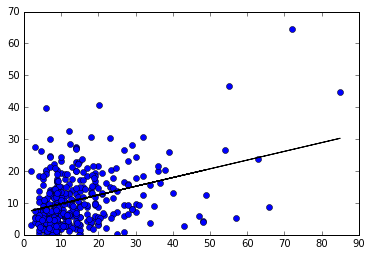

In [29]:
import pylab

predict_y = intercept + slope * result.PM25_Soton_Centre

pylab.plot(result.PM25_Soton_Centre,result.MAIAC_PM25, 'o')
pylab.plot(result.PM25_Soton_Centre, predict_y, 'k-')
pylab.show()

# Validating Bournemouth
## Extracting data at the ground site

In [8]:
a = MAIAC_PM25.attrs['affine']
a = rasterio.Affine.from_gdal(*a)
~a * (412322, 93343)

(1082.3040538889738, 1063.182688636608)

In [ ]:
PM25 = xr.open_mfdataset(r'C:\MAIACData\nc_monthly_daily\*PM25.nc', concat_dim='time')

In [ ]:
ts = PM25['data'].isel(x=1082, y=1063).dropna('time')

In [ ]:
ts

In [ ]:
result = ts.load()

In [ ]:
result = result.to_dataframe()

In [ ]:
result.dropna()

In [ ]:
result.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_MAIAC_PM25_daily.csv')

# Validating Bournemouth
## Extracting data at the ground site on daily data

In [31]:
MAIAC_Bmth = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_MAIAC_PM25_daily.csv')

In [32]:
MAIAC_Bmth[:10]

,time,x,y,data
0,2000-10-01,411939.943201,93572.556136,12.497609
1,2000-10-10,411939.943201,93572.556136,10.441040
2,2000-10-12,411939.943201,93572.556136,20.723885
3,2000-10-19,411939.943201,93572.556136,18.034525
4,2000-10-26,411939.943201,93572.556136,8.463571
5,2000-10-30,411939.943201,93572.556136,7.988977
6,2000-10-31,411939.943201,93572.556136,7.751681
7,2000-11-03,411939.943201,93572.556136,11.357734
8,2000-11-04,411939.943201,93572.556136,7.901032
9,2000-11-12,411939.943201,93572.556136,3.061650


In [33]:
MAIAC_Bmth = MAIAC_Bmth.set_index('time')

In [34]:
AURN_Bmth = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bournemouth2008_2014.csv')

In [35]:
AURN_Bmth[:10]

,Date,PM2.5 particulate matter (Daily measured),Status
0,12/03/2009,0.0,V ugm-3 (GRAV EMFAB)
1,30/11/2009,0.0,V ugm-3 (GRAV EMFAB)
2,25/12/2013,0.0,V ugm-3 (GRAV EMFAB)
3,27/12/2009,1.0,V ugm-3 (GRAV EMFAB)
4,16/02/2010,1.0,V ugm-3 (GRAV EMFAB)
5,22/08/2010,1.0,V ugm-3 (GRAV EMFAB)
6,29/08/2010,1.0,V ugm-3 (GRAV EMFAB)
7,21/09/2010,1.0,V ugm-3 (GRAV EMFAB)
8,17/01/2011,1.0,V ugm-3 (GRAV EMFAB)
9,26/08/2011,1.0,V ugm-3 (GRAV EMFAB)


In [36]:
AURN_Bmth['timestamp'] = pd.to_datetime(AURN_Bmth.Date, format='%d/%m/%Y')

In [37]:
AURN_Bmth = AURN_Bmth.set_index('timestamp')

In [38]:
AURN_Bmth['PM2.5 particulate matter (Daily measured)'].astype(float)

timestamp
2009-03-12     0.00
2009-11-30     0.00
2013-12-25     0.00
2009-12-27     1.00
2010-02-16     1.00
2010-08-22     1.00
2010-08-29     1.00
2010-09-21     1.00
2011-01-17     1.00
2011-08-26     1.00
2011-09-05     1.00
2012-04-29     1.00
2012-12-20     1.00
2012-12-22     1.00
2014-06-04     1.29
2013-09-13     1.50
2013-05-23     1.71
2014-04-06     1.75
2014-01-10     1.88
2014-02-07     1.88
2014-02-19     1.92
2009-03-13     2.00
2009-07-09     2.00
2009-07-11     2.00
2009-07-17     2.00
2009-08-26     2.00
2009-11-02     2.00
2009-11-27     2.00
2009-12-17     2.00
2009-12-26     2.00
              ...  
2012-03-25    34.00
2010-11-06    35.00
2009-01-02    36.00
2009-03-21    36.00
2012-10-24    36.00
2013-04-10    36.17
2013-03-04    36.72
2012-01-31    37.00
2009-01-04    38.00
2009-01-08    38.00
2009-02-24    38.00
2011-03-18    38.00
2012-02-12    38.00
2012-03-14    38.00
2013-04-08    38.67
2012-03-02    40.00
2009-03-18    41.00
2010-01-27    41.00
2014-03-14

In [39]:
Bmth_result = pd.merge(AURN_Bmth, MAIAC_Bmth, left_index=True, right_index=True).reset_index().rename(columns={'data':'MAIAC_PM25', 'index':'Date', 'Date':'Delete',
                                                                                                          'PM2.5 particulate matter (Daily measured)':'AURN_Bmth_PM25'})

In [40]:
Bmth_result[:10]

,Date,Delete,AURN_Bmth_PM25,Status,x,y,MAIAC_PM25
0,2009-10-08,08/10/2009,6.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,8.424021
1,2009-10-12,12/10/2009,5.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,7.356187
2,2009-10-13,13/10/2009,11.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,11.627522
3,2009-10-14,14/10/2009,12.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,23.966932
4,2009-10-16,16/10/2009,15.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,25.469810
5,2009-10-17,17/10/2009,8.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,20.011995
6,2009-10-18,18/10/2009,13.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,21.040277
7,2009-10-25,25/10/2009,6.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,19.418751
8,2009-10-27,27/10/2009,8.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,9.570953
9,2009-11-04,04/11/2009,3.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,11.654023


In [41]:
Bmth_result = Bmth_result.set_index('Date')

In [42]:
Bmth_result = Bmth_result[['AURN_Bmth_PM25', 'MAIAC_PM25']].dropna()

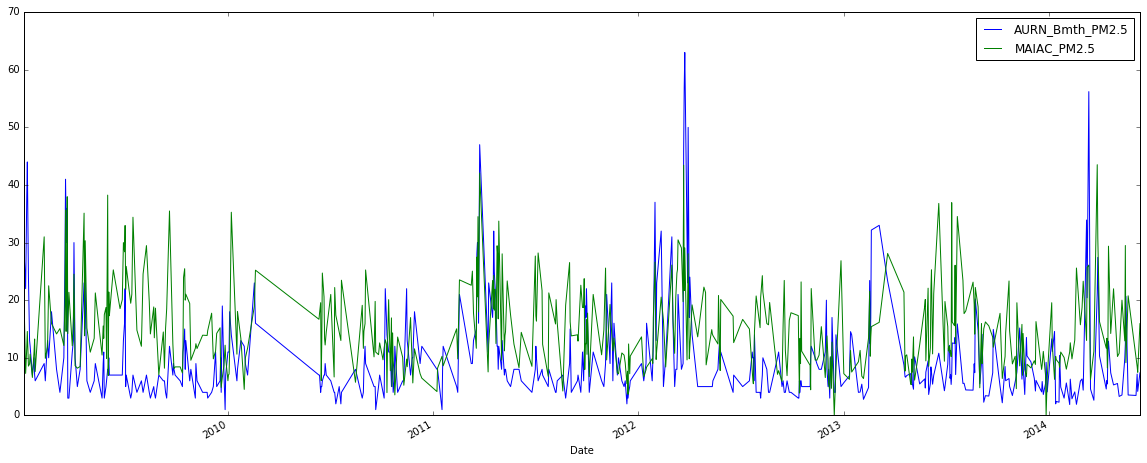

In [67]:
Bmth_result.plot(figsize=(20, 8))
savefig(r'D:\Annies_Dissertation\Analysis\Bmth_validation_graph.jpeg')

In [43]:
Bmth_result['error'] = Bmth_result['AURN_Bmth_PM25'] - Bmth_result['MAIAC_PM25']

In [49]:
Bmth_result.error.abs().describe()

count    499.000000
mean       8.147670
std        6.287683
min        0.028516
25%        3.323876
50%        6.650052
75%       11.831492
max       35.325407
Name: error, dtype: float64

In [91]:
Bmth_result.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_validation.csv')

In [80]:
Bmth_result.ix[Bmth_result.MAIAC_PM25 > 25]

,AURN_Bmth_PM25,MAIAC_PM25,error
Date,,,
2009-10-16,15.00,25.469810,-10.469810
2009-02-08,9.00,30.999813,-21.999813
2009-03-18,41.00,35.642666,5.357334
2009-03-21,36.00,37.963379,-1.963379
2009-04-20,23.00,35.108669,-12.108669
2009-04-22,23.00,30.321121,-7.321121
2009-06-01,8.00,38.241444,-30.241444
2009-06-11,7.00,25.265444,-18.265444
2009-06-29,13.00,30.002712,-17.002712


In [81]:
Bmth_result.ix[Bmth_result.AURN_Bmth_PM25 > 25]

,AURN_Bmth_PM25,MAIAC_PM25,error
Date,,,
2009-01-03,29.00,20.831419,8.168581
2009-01-08,38.00,11.755879,26.244121
2009-01-09,44.00,14.577291,29.422709
2009-03-17,27.00,19.529028,7.470972
2009-03-18,41.00,35.642666,5.357334
2009-03-19,34.00,14.581090,19.418910
2009-03-20,30.00,22.112465,7.887535
2009-03-21,36.00,37.963379,-1.963379
2009-04-02,30.00,24.518036,5.481964


In [82]:
Bmth_result.ix[Bmth_result.MAIAC_PM25 > 10]

,AURN_Bmth_PM25,MAIAC_PM25,error
Date,,,
2009-10-13,11.00,11.627522,-0.627522
2009-10-14,12.00,23.966932,-11.966932
2009-10-16,15.00,25.469810,-10.469810
2009-10-17,8.00,20.011995,-12.011995
2009-10-18,13.00,21.040277,-8.040277
2009-10-25,6.00,19.418751,-13.418751
2009-11-04,3.00,11.654023,-8.654023
2009-11-05,9.00,12.444126,-3.444126
2009-11-07,6.00,11.604641,-5.604641


In [83]:
Bmth_result.ix[Bmth_result.AURN_Bmth_PM25 > 10]

,AURN_Bmth_PM25,MAIAC_PM25,error
Date,,,
2009-10-13,11.00,11.627522,-0.627522
2009-10-14,12.00,23.966932,-11.966932
2009-10-16,15.00,25.469810,-10.469810
2009-10-18,13.00,21.040277,-8.040277
2009-12-10,11.00,11.162719,-0.162719
2009-12-22,19.00,6.578994,12.421006
2009-01-03,29.00,20.831419,8.168581
2009-01-06,22.00,7.288646,14.711354
2009-01-08,38.00,11.755879,26.244121


In [87]:
Bmth_result.MAIAC_PM25.describe()

count    499.000000
mean      14.931897
std        7.431676
min        0.000000
25%        9.575478
50%       13.383366
75%       19.443021
max       43.524334
Name: MAIAC_PM25, dtype: float64

In [86]:
Bmth_result.AURN_Bmth_PM25.describe()

count    499.000000
mean      10.097695
std        8.462929
min        1.000000
25%        5.000000
50%        7.250000
75%       12.000000
max       63.000000
Name: AURN_Bmth_PM25, dtype: float64

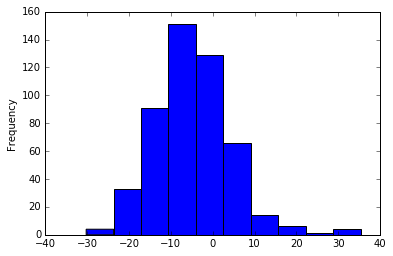

In [38]:
Bmth_error_histo = Bmth_result.error.plot.hist()
savefig(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_error_histo.jpeg')

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_true = Bmth_result.AURN_Bmth_PM25, y_pred = Bmth_result.MAIAC_PM25))
rmse

10.287869003548673

In [44]:
from sklearn.metrics import mean_absolute_error
me = mean_absolute_error(y_true = Bmth_result.AURN_Bmth_PM25, y_pred = Bmth_result.MAIAC_PM25)
me

8.1476695061876683

In [44]:
Bmth_result.corr()

,AURN_Bmth_PM25,MAIAC_PM25,error
AURN_Bmth_PM25,1.000000,0.351503,0.643607
MAIAC_PM25,0.351503,1.000000,-0.490287
error,0.643607,-0.490287,1.000000


In [45]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(Bmth_result.AURN_Bmth_PM25,Bmth_result.MAIAC_PM25)
print("r-squared:", r_value**2)
print("p-value:", p_value)
print("Slope:", slope)

r-squared: 0.123554063475
p-value: 5.87274171914e-16
Slope: 0.308670116971


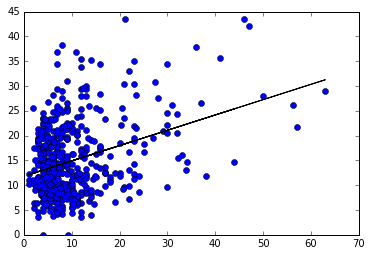

In [50]:
import pylab

predict_y = intercept + slope * Bmth_result.AURN_Bmth_PM25

pylab.plot(Bmth_result.AURN_Bmth_PM25,Bmth_result.MAIAC_PM25, 'o')
pylab.plot(Bmth_result.AURN_Bmth_PM25, predict_y, 'k-')
pylab.show()
pylab.savefig(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_regression.jpeg')